<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Figure-16.1" data-toc-modified-id="Figure-16.1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Figure 16.1</a></span></li><li><span><a href="#Figure-16.2" data-toc-modified-id="Figure-16.2-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 16.2</a></span></li></ul></div>

In [1]:
## Analyzing Neural Time Series Data
# Python code for Chapter 16
# Yujin Goto (MATLAB original code: Mike X Cohen)
# 
# This code accompanies the book, titled "Analyzing Neural Time Series Data" 
# (MIT Press). Using the code without following the book may lead to confusion, 
# incorrect data analyses, and misinterpretations of results. 
# Mike X Cohen and Yujin Goto assumes no responsibility for inappropriate or incorrect use of this code. 

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import signal as sig

import mne
from mne import events_from_annotations

In [3]:
# load EEG data (.vhdr converted ver. by Yujin)
mne.set_log_level('CRITICAL') # delete this line for your environment
raw = mne.io.read_raw_brainvision('./NeuralData/sampleEEGdata_convert.vhdr', eog=['HEOG', 'VEOG'], preload=True)
mne.set_log_level('INFO') # delete this line for your environment

# load electrodes location montage
montage = mne.channels.read_custom_montage('./NeuralData/sampleEEG_loc.loc')
raw.set_montage(montage)

# Getting event timings (for .mat file, you don't have to do this.) and epoching
events, event_dict = events_from_annotations(raw)

epochs = mne.Epochs(
    raw,
    events,
    event_id = {'New Segment/': 99999},
    tmin = 0,
    tmax = 2.496,
    baseline = None,
)

# Extract variables
data = epochs.get_data()*(10**6)                 # EEG data (array; trial, ch, time). MNE-pyton reads data in volts(V), not microvolts (μV).
pnts = data.shape[2]                             # Number of points in EEG data (scalar)
times = epochs.times-1                           # Time points of data (array)
tmin = epochs.tmin-1                             # The start timing of epoch (the start timing of the baseline is set to be 0 in default)
tmax = epochs.tmax-1                             # The end timing of epoch
srate = epochs.info['sfreq']                     # Sampling rate (scalar)
trials = len(epochs.events)                      # Trials (scalar)
nbchan = len(epochs.ch_names)                    # Number of channel (scalar)


chan_labels = epochs.info['ch_names']

# channel locations
chan_pos = []
for ch in epochs.info['chs']:
    x,y,z = ch['loc'][:3]
    chan_pos.append((x,y,z))

Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/2', 'Stimulus/31', 'Stimulus/32', 'Stimulus/51', 'Stimulus/52']
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 99 events and 640 original time points ...
0 bad epochs dropped


## Figure 16.1

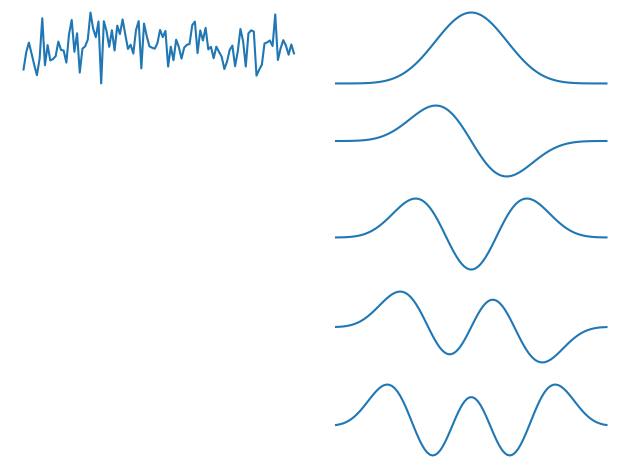

In [4]:
channel2plot = 'O1';
timewin      = 400 # in ms
timewinidx = int(np.round(timewin/(1000/srate)))


tapers = sig.windows.dpss(M=timewinidx,NW=5,Kmax=5)

# extract a bit of EEG data
d = sig.detrend(data[9, chan_labels.index(channel2plot),199:199+timewinidx])

# plot eeg data snippet
plt.subplot(5,2,1)
plt.plot(d)
plt.axis('off')

# plot tapers
for i in range(5):
    plt.subplot(5,2,(2*i)+2)
    plt.plot(tapers[i,:])
    plt.axis('off')


plt.tight_layout()

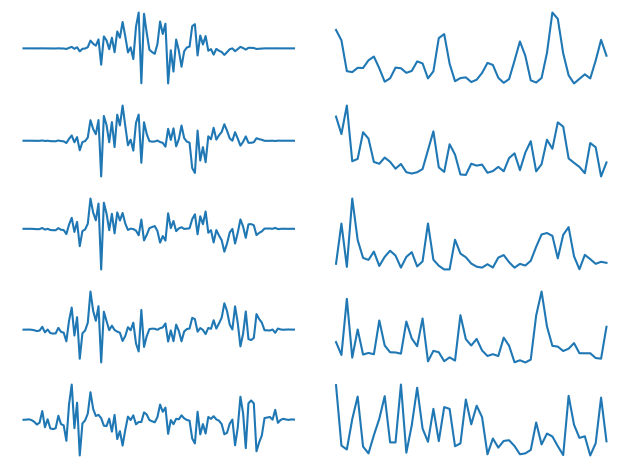

In [5]:
# plot taper*data
for i in range(5):
    plt.subplot(5,2,(2*(i))+1)
    plt.plot(tapers[i,:]*d) #multiply data by tapers
    plt.axis('off')

# plot fft of taper.*data
f=np.zeros([5,timewinidx]) * 1j

for i in range(5):
    plt.subplot(5,2,(2*(i))+2)
    f[i,:]=np.fft.fft(tapers[i,:]*d)
    plt.plot(np.abs(f[i,:int(timewinidx/2)])**2)
    plt.axis('off')
    
plt.tight_layout()

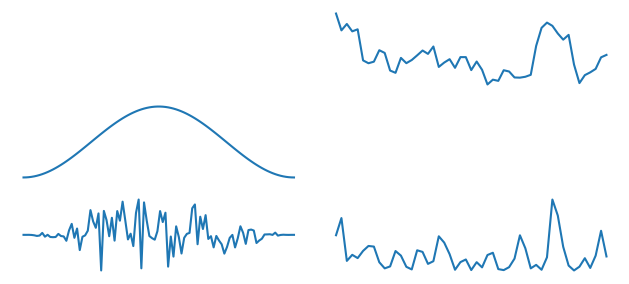

In [6]:
plt.subplot(5,2,2)
plt.plot(np.mean(np.abs(f[:,:timewinidx//2])**2,axis=0))
plt.axis('off')

plt.subplot(5,2,3)
hann = .5*(1-np.cos(2*np.pi*np.arange(timewinidx)/(timewinidx-1)));
plt.plot(hann)
plt.axis('off')

plt.subplot(5,2,5)
plt.plot(hann*d)
plt.axis('off')

plt.subplot(5,2,6)
ff=np.fft.fft(hann*d);
plt.plot((np.abs(ff[:timewinidx//2])**2))
plt.axis('off')

plt.tight_layout()

## Figure 16.2

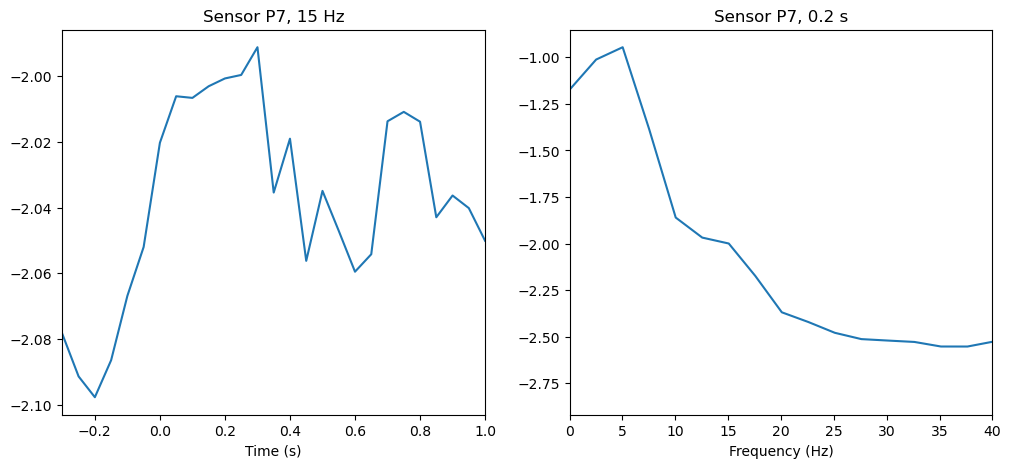

In [7]:
channel2plot    = 'P7'
frequency2plot  = 15  # in Hz
timepoint2plot  = .2 # s

nw_product      = 3 #  determines the frequency smoothing, given a specified time window
times2save      = np.arange(-.3,1+.05,.05)
baseline_range  = np.array([-200, -0])
timewin         = 400 # in ms

def dsearchn(X, p):
    disp = X - p
    return np.argmin((disp*disp))

# convert time points to indices
times2saveidx = [dsearchn(times,x) for x in times2save]
timewinidx    = np.round(timewin/(1000/srate)).astype(int)

# find baselinetimepoints
baseidx = np.zeros(baseline_range.shape);
baseidx[0] = np.argmin(np.abs(times2save - baseline_range[0]))
baseidx[1] = np.argmin(np.abs(times2save - baseline_range[1]))

# note that the following line is equivalent to the previous three
# baseidx = dsearchn(times2save',baseline_range');

# define tapers
# note that in practice, you'll want to set the temporal resolution to be a function of frequency
tapers = sig.windows.dpss(timewinidx,nw_product,6).T
# define frequencies for FFT
f = np.linspace(0,srate/2,(timewinidx//2)+1)

# find logical channel index
chanidx = chan_labels.index(channel2plot)

#initialize output matrix
multitaper_tf = np.zeros([int(np.floor(timewinidx/2)+1),len(times2save)])

# loop through time bins
for ti in range(len(times2saveidx)):
    
    #% initialize power vector (over tapers)
    taperpow = np.zeros(int(np.floor(timewinidx/2)+1)) * 1j
    
    #loop through tapers
    for tapi in range(1, tapers.shape[1]-1):
        
        # window and taper data, and get pwoer spectrum
        datas = data[:, chanidx, int(times2saveidx[ti]-np.floor(timewinidx/2)):int(times2saveidx[ti]+np.ceil(timewinidx/2))].T
        datas_tape = datas * np.reshape(tapers[:,tapi], [tapers.shape[0],1])
        pow_ = np.fft.fft(datas_tape,n=timewinidx,axis=0)/timewinidx
        pow_ = pow_[:int(np.floor(timewinidx/2)+1),:]
        taperpow = taperpow + np.mean(pow_ * np.conj(pow_),axis=1)
        
        #finally get power from closest frequency (should be real)
        multitaper_tf[:,ti] = np.real(taperpow/tapi)
        
#db-correct
db_multitaper_tf = 10*np.log10( multitaper_tf/np.tile(np.mean(multitaper_tf[:,int(baseidx[0]):int(baseidx[1])],axis=1),[len(times2save),1]).T)

# plot time courses at one frequency band
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
freq2plotidx = np.argmin(np.abs(f-frequency2plot))
plt.plot(times2save,np.mean(np.log10(multitaper_tf[freq2plotidx-2:freq2plotidx+2,:]),axis=0))
plt.setp(plt.gca(), 'xlim', [times2save[0],times2save[-1]], 'xlabel', 'Time (s)','title', 'Sensor ' + channel2plot + ', ' + str(frequency2plot) + ' Hz')

plt.subplot(1,2,2)
time2plotidx = np.argmin(np.abs(times2save-timepoint2plot));
plt.plot(f,np.log10(multitaper_tf[:,time2plotidx]))
_=plt.setp(plt.gca(),'xlim',[f[0], 40], 'xlabel', 'Frequency (Hz)','title', 'Sensor ' + channel2plot + ', ' + str(timepoint2plot) + ' s')

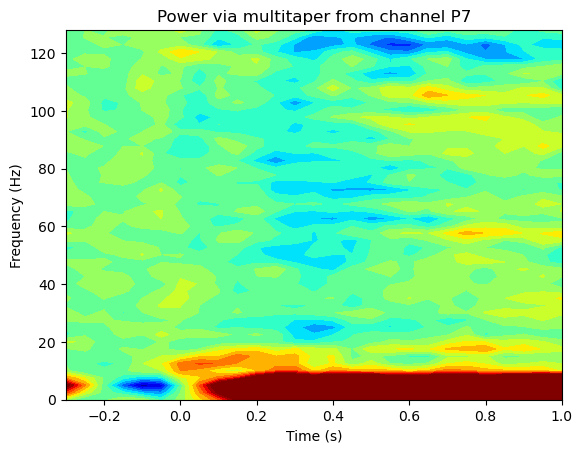

In [8]:
# plot full TF map
plt.contourf(times2save,f,db_multitaper_tf,40, cmap= 'jet')
plt.clim([-2,2])
_=plt.setp(plt.gca(), 'xlabel', 'Time (s)', 'ylabel', 'Frequency (Hz)', 'title', 'Power via multitaper from channel ' + channel2plot )